In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install diffusers transformers accelerate scipy safetensors

In [3]:
!pip install pillow


In [4]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 463 (delta 175), reused 136 (delta 136), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 32.71 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [5]:
cd /kaggle/working/GroundingDINO

/kaggle/working/GroundingDINO


In [6]:
pip install -e .

Obtaining file:///kaggle/working/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 14.2 MB/s eta 0:00:00
  Running setup.py develop for groundingdino
Note: you may need to restart the kernel to use updated packages.


In [8]:
mkdir weights

mkdir: cannot create directory ‘weights’: File exists


In [9]:
cd weights

/kaggle/working/GroundingDINO/weights


In [10]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth


In [11]:
cd ..

/kaggle/working/GroundingDINO


##** Code for detection ( ****each phrases individually) and then merge and together give in one image**# assert

In [12]:
import os
import torch
import numpy as np
from PIL import Image
from groundingdino.util.inference import load_image, predict, annotate
from groundingdino.util.utils import clean_state_dict
from groundingdino.models import build_model
from torchvision.ops import box_convert

# Import SLConfig to resolve the issue
from groundingdino.util.slconfig import SLConfig  # Add this import

# Your model loading function
def load_model_hf(ckpt_filename, config_file):
    args = SLConfig.fromfile(config_file)  # This should now work with the import
    model = build_model(args)
    checkpoint = torch.load(ckpt_filename, map_location="cpu")
    state_dict = clean_state_dict(checkpoint["model"])
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
    model.load_state_dict(filtered_state_dict, strict=False)
    return model

# Load model
ckpt_filename = "/kaggle/working/GroundingDINO/weights/groundingdino_swint_ogc.pth"
ckpt_config_filename = "/kaggle/working/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
model = load_model_hf(ckpt_filename, ckpt_config_filename)

# Prediction and annotation utilities
def generate_masks_with_grounding(image_source, boxes):
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask

def get_highest_prob_boxes(logits, phrases, boxes):
    phrase_to_data = {}
    for i, phrase in enumerate(phrases):
        if phrase not in phrase_to_data:
            # Save the initial data for this phrase
            phrase_to_data[phrase] = (logits[i], boxes[i], phrase)
        else:
            # Update if the current box has a higher probability
            current_prob, _, _ = phrase_to_data[phrase]
            if logits[i] > current_prob:
                phrase_to_data[phrase] = (logits[i], boxes[i], phrase)

    # Extract the data with the highest probability for each unique phrase
    highest_prob_data = list(phrase_to_data.values())
    
    # Separate into logits, boxes, and phrases
    highest_logits = torch.tensor([item[0] for item in highest_prob_data])
    highest_boxes = torch.stack([item[1] for item in highest_prob_data])
    highest_phrases = [item[2] for item in highest_prob_data]

    return highest_logits, highest_boxes, highest_phrases

# List of text prompts for detection
TEXT_PROMPTS = ["turtle"]

# Set thresholds
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.20

# Load image
image_source, image = load_image("/kaggle/input/images/scene_3_normal.png")

# Initialize lists to store aggregated results
all_highest_logits = []
all_highest_boxes = []
all_highest_phrases = []

# Loop through each text prompt and process predictions
for prompt in TEXT_PROMPTS:
    # Get predictions (bounding boxes and associated probabilities)
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=prompt,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )

    # Get highest probability boxes, logits, and phrases for the current prompt
    highest_logits, highest_prob_boxes, highest_phrases = get_highest_prob_boxes(logits, phrases, boxes)

    # Append results to the aggregated lists
    all_highest_logits.append(highest_logits)
    all_highest_boxes.append(highest_prob_boxes)
    all_highest_phrases.extend(highest_phrases)

# Concatenate all the results into single tensors/lists
final_highest_logits = torch.cat(all_highest_logits, dim=0)
final_highest_boxes = torch.cat(all_highest_boxes, dim=0)
final_highest_phrases = all_highest_phrases

# Annotate the image with predictions from all prompts
annotated_frame = annotate(
    image_source=image_source,
    boxes=final_highest_boxes,
    logits=final_highest_logits,
    phrases=final_highest_phrases
)
annotated_frame = annotated_frame[..., ::-1]  # BGR to RGB
Image.fromarray(annotated_frame).save("/kaggle/working/multi_prompt_annotatedv1.png")

# Generate masks using these highest probability boxes
image_mask = generate_masks_with_grounding(image_source, final_highest_boxes)
Image.fromarray(image_mask).save("/kaggle/working/multi_prompt_maskv1.png")

# Optionally, print the results for debugging
print("Final Highest Probability Boxes:", final_highest_boxes)
print("Final Highest Probability Phrases:", final_highest_phrases)
print("Final Highest Probability Logits:", final_highest_logits)


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Final Highest Probability Boxes: tensor([[0.3979, 0.5451, 0.2627, 0.2612]])
Final Highest Probability Phrases: ['turtle']
Final Highest Probability Logits: tensor([0.7752])


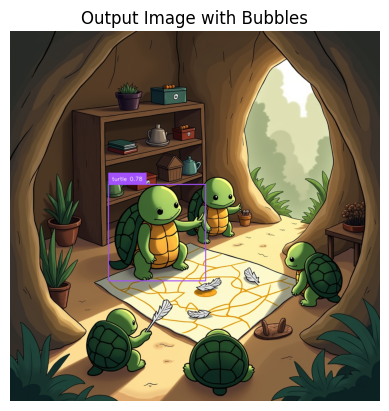

In [13]:
import cv2
import matplotlib.pyplot as plt

# Path to the image
image_path = '/kaggle/working/multi_prompt_annotatedv1.png'

# Read the image using OpenCV
img = cv2.imread(image_path)

# Convert the image from BGR (OpenCV's default) to RGB for Matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(img_rgb)
plt.title('Output Image with Bubbles')
plt.axis('off')  # Hide axis labels
plt.show()

In [14]:
#Now on this image image_path = '/kaggle/working/multi_prompt_annotatedv1.png' add text code

In [19]:
import textwrap
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont

# Your data
final_highest_boxes = torch.tensor([[0.3979, 0.5451, 0.2627, 0.2612]])
final_highest_phrases = ['turtle']
dialogues = {
    "turtle": "Let's see"
}

# Load source image
source_img_path = "/kaggle/input/images/scene_3_normal.png"  # Update this to your actual image path
image = Image.open(source_img_path)
w, h = image.size

def draw_dialogue_bubbles(image, boxes, phrases, dialogues):
    """
    Draw dialogue bubbles near bounding boxes with specified phrases.
    """
    draw = ImageDraw.Draw(image)

    # Try to load a font; fallback to default PIL font if unavailable
    try:
        font = ImageFont.truetype("arial.ttf", 14)  # Update to your system font path if needed
    except IOError:
        font = ImageFont.load_default()

    for i, box in enumerate(boxes):
        # Convert normalized box to pixel coordinates
        x_center, y_center, box_width, box_height = box.numpy()
        x_center *= w
        y_center *= h
        box_width *= w
        box_height *= h

        # Dialogue text
        dialogue = dialogues.get(phrases[i], "")

        # Bubble dimensions
        bubble_width = 150
        bubble_height = 50
        padding = 10  # Padding inside the bubble for text

        # Wrap text to fit inside the bubble width
        wrapped_text = textwrap.fill(dialogue, width=int(bubble_width // (font.size * 0.6)))
        lines = wrapped_text.split("\n")
        line_height = font.size
        bubble_height = max(bubble_height, len(lines) * line_height + padding * 2)

        # Determine bubble position
        bubble_x = x_center
        bubble_y = y_center - box_height / 2 - bubble_height - 10  # Default above the box

        # Adjust bubble position if it goes out of bounds
        if bubble_y < 0:  # If at top edge, place below or to the side
            bubble_y = y_center + box_height / 2 + 10

        # Define bubble bounds
        bubble_bounds = [
            bubble_x - bubble_width / 2,
            bubble_y - bubble_height,
            bubble_x + bubble_width / 2,
            bubble_y
        ]

        # Draw the bubble (ellipse)
        draw.ellipse(bubble_bounds, fill=(255, 255, 255), outline=(0, 0, 0), width=2)

        # Number of tail circles to create more connection between the bubble and the character
        tail_segments = 3
        tail_radius = 5
        tail_spacing = 18  # Spacing between each circle in the tail

        # Draw multiple small circles for the tail
        for j in range(tail_segments):
            tail_x = x_center
            tail_y = y_center - box_height / 2 - (j + 1) * tail_spacing
            draw.ellipse(
                [tail_x - tail_radius, tail_y - tail_radius,
                 tail_x + tail_radius, tail_y + tail_radius],
                fill=(255, 255, 255), outline=(0, 0, 0), width=2
            )

        # Center the text inside the bubble
        total_text_height = len(lines) * line_height
        text_start_y = bubble_y - bubble_height + (bubble_height - total_text_height) / 2

        for line in lines:
            text_width = draw.textlength(line, font=font)
            text_start_x = bubble_x - text_width / 2
            draw.text((text_start_x, text_start_y), line, fill=(0, 0, 0), font=font)
            text_start_y += line_height  # Move to the next line

    return image



image_with_bubbles = draw_dialogue_bubbles(image, final_highest_boxes, final_highest_phrases, dialogues)

# Save the result
output_path = "/kaggle/working/scene_3_normal.png_final.jpg"  # Update this to your desired output path
image_with_bubbles.save(output_path)

print(f"Annotated image saved to {output_path}")


Annotated image saved to /kaggle/working/scene_3_normal.png_final.jpg


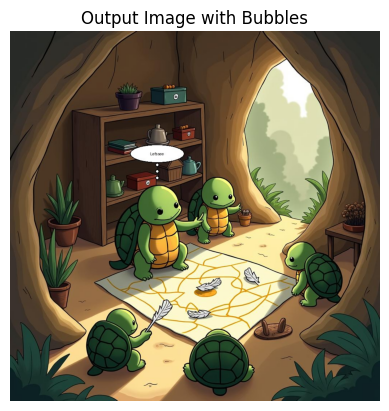

In [20]:
import cv2
import matplotlib.pyplot as plt

# Path to the image
image_path = '/kaggle/working/scene_3_normal.png_final.jpg'

# Read the image using OpenCV
img = cv2.imread(image_path)

# Convert the image from BGR (OpenCV's default) to RGB for Matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(img_rgb)
plt.title('Output Image with Bubbles')
plt.axis('off')  # Hide axis labels
plt.show()